In [63]:
# !pip install numpy pandas scikit-allel matplotlib
import gzip
import pandas as pd
from pandas_plink import read_plink
from sklearn.preprocessing import StandardScaler
import os
# import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr


In [19]:
# Load genotype data using pandas-plink
plink_file_prefix = './chr22_data'  # Modify for other chromosomes if needed
(bim, fam, bed) = read_plink(plink_file_prefix)

Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4005050199.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(plink_file_prefix)
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4005050199.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(plink_file_prefix)
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 47.68it/s]


In [20]:
print(f"FAM file: \n{fam.head()}")

FAM file: 
  fid         iid father mother gender trait  i
0   0  GTEX-111CU      0      0      0    -9  0
1   0  GTEX-111FC      0      0      0    -9  1
2   0  GTEX-111VG      0      0      0    -9  2
3   0  GTEX-111YS      0      0      0    -9  3
4   0  GTEX-1122O      0      0      0    -9  4


In [21]:
print(f"FAM file: \n{bim.head()}")

FAM file: 
  chrom         snp   cm       pos a0 a1  i
0    22    rs131538  0.0  16390411  A  G  0
1    22   rs7287144  0.0  16406147  G  A  1
2    22   rs5747620  0.0  16551808  C  T  2
3    22  rs17430900  0.0  16573137  A  G  3
4    22   rs9605903  0.0  16573830  C  T  4


In [22]:
# Extract the sample IDs from the FAM file
genotype_sample_ids = fam['iid'].tolist()

In [23]:
# Load the gene expression sample IDs (similar to before)
gene_expression_file = 'Whole_Blood.v8.normalized_expression.bed'

gene_expression_data = pd.read_csv(gene_expression_file, sep='\t')

In [24]:
# extract chr22
gene_expression_data=gene_expression_data[gene_expression_data['#chr'] == 'chr22']

In [25]:
gene_expression_data.head()

,#chr,start,end,gene_id,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZV7C,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
19122,chr22,16601886,16601887,ENSG00000100181.22,1.570734,-0.770282,-1.353622,0.512862,-0.853391,-0.560321,...,1.120983,-1.821345,2.214046,1.217151,-0.902828,0.376684,1.265581,-0.954578,0.001868,0.919804
19123,chr22,16612581,16612582,ENSG00000283633.1,1.747926,-0.996665,-0.582310,-1.545582,0.372677,0.231802,...,1.073249,-1.040597,1.178870,1.114008,-0.534285,2.259617,1.079918,-0.133007,0.144322,1.209352
19124,chr22,16821698,16821699,ENSG00000172967.7,0.869633,-0.417104,-1.197791,0.735562,-0.254890,-1.197791,...,0.948702,-0.392775,1.382185,0.740467,-1.197791,-0.293681,1.714493,-1.197791,-0.095404,0.061677
19125,chr22,17036569,17036570,ENSG00000237438.7,1.232973,-1.034199,-0.931270,-0.182182,-1.432461,0.595640,...,-0.720952,-1.073249,0.095404,-1.765402,0.573481,-1.498020,0.328973,-0.336870,0.227967,-0.340827
19126,chr22,17067820,17067821,ENSG00000273203.1,-0.696937,-0.750331,-0.069165,0.687444,-0.491673,-1.396898,...,0.388743,0.099157,0.960486,0.348756,-1.396898,-0.243330,1.558035,-0.325032,-0.151876,0.569083


In [26]:
# Define ±500 kb windows for each gene
genes_on_chrom = gene_expression_data[['gene_id', "#chr", 'start', 'end']]
genes_on_chrom['window_start'] = genes_on_chrom['start'].apply(lambda x: max(0, x - 500000))
genes_on_chrom['window_end'] = genes_on_chrom['end'] + 500000

/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/874599569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_on_chrom['window_start'] = genes_on_chrom['start'].apply(lambda x: max(0, x - 500000))
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/874599569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_on_chrom['window_end'] = genes_on_chrom['end'] + 500000


In [27]:
gene_expression_data.head(10)

,#chr,start,end,gene_id,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZV7C,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
19122,chr22,16601886,16601887,ENSG00000100181.22,1.570734,-0.770282,-1.353622,0.512862,-0.853391,-0.560321,...,1.120983,-1.821345,2.214046,1.217151,-0.902828,0.376684,1.265581,-0.954578,0.001868,0.919804
19123,chr22,16612581,16612582,ENSG00000283633.1,1.747926,-0.996665,-0.582310,-1.545582,0.372677,0.231802,...,1.073249,-1.040597,1.178870,1.114008,-0.534285,2.259617,1.079918,-0.133007,0.144322,1.209352
19124,chr22,16821698,16821699,ENSG00000172967.7,0.869633,-0.417104,-1.197791,0.735562,-0.254890,-1.197791,...,0.948702,-0.392775,1.382185,0.740467,-1.197791,-0.293681,1.714493,-1.197791,-0.095404,0.061677
19125,chr22,17036569,17036570,ENSG00000237438.7,1.232973,-1.034199,-0.931270,-0.182182,-1.432461,0.595640,...,-0.720952,-1.073249,0.095404,-1.765402,0.573481,-1.498020,0.328973,-0.336870,0.227967,-0.340827
19126,chr22,17067820,17067821,ENSG00000273203.1,-0.696937,-0.750331,-0.069165,0.687444,-0.491673,-1.396898,...,0.388743,0.099157,0.960486,0.348756,-1.396898,-0.243330,1.558035,-0.325032,-0.151876,0.569083
19127,chr22,17084953,17084954,ENSG00000177663.13,0.564697,1.980120,-0.266485,-0.569083,-0.151876,-0.984462,...,2.099561,-0.106668,0.247180,1.596922,-1.980120,-0.227967,1.765402,-2.099561,0.289783,0.039235
19128,chr22,17093938,17093939,ENSG00000235328.1,-0.604585,1.257303,0.826808,0.392775,0.564697,-0.755291,...,1.624253,1.021528,-0.148098,0.902828,-1.802066,0.886109,0.790544,-1.265581,0.148098,-0.170799
19129,chr22,17121366,17121367,ENSG00000183307.3,0.780373,1.120983,-0.445806,0.396813,-0.293681,-0.765266,...,1.521370,-0.483259,0.663975,0.352728,-1.201627,-0.609076,2.099561,-1.610437,1.624253,-0.197397
19130,chr22,17121585,17121586,ENSG00000235478.4,0.591185,0.054194,-1.047038,0.474879,-0.600107,-0.061677,...,1.372539,0.121709,0.864194,0.254890,-0.437569,0.091652,1.906141,-0.144322,1.475458,0.740467
19131,chr22,17165267,17165268,ENSG00000069998.12,1.164031,-0.282000,-2.259617,1.120983,-1.282401,-0.254890,...,0.133007,0.521402,2.514430,0.117946,-0.696937,0.148098,-0.529981,-1.422116,0.301491,0.344789


In [28]:
# Gene expression sample columns (excluding the metadata columns)
expression_sample_ids = gene_expression_data.columns[4:]  # Adjust if necessary
expression_sample_ids

Index(['GTEX-111YS', 'GTEX-1122O', 'GTEX-1128S', 'GTEX-113IC', 'GTEX-113JC',
       'GTEX-117XS', 'GTEX-117YW', 'GTEX-1192W', 'GTEX-1192X', 'GTEX-11DXX',
       ...
       'GTEX-ZV7C', 'GTEX-ZVE2', 'GTEX-ZVP2', 'GTEX-ZVT2', 'GTEX-ZVT3',
       'GTEX-ZVT4', 'GTEX-ZVZP', 'GTEX-ZVZQ', 'GTEX-ZXES', 'GTEX-ZXG5'],
      dtype='object', length=670)

In [29]:
# Get the sample IDs from the .fam file
fam_lin_sample_ids = fam['iid'].tolist()

In [30]:
common_sample_ids = [sid for sid in expression_sample_ids if sid in genotype_sample_ids]

# Get the indices of the common samples in the genotype matrix
common_sample_indices = [genotype_sample_ids.index(sid) for sid in common_sample_ids]

# Filter genotype matrix for common samples (489 individuals and 185 SNPs)
genotype_matrix = bed.compute()[:, common_sample_indices]  # Filter genotype matrix based on common samples


In [31]:

# Filter gene expression values for the same common samples
y = gene_expression_data[common_sample_ids].values#.flatten()


In [32]:
y

array([[ 1.57073416e+00, -7.70281989e-01, -1.35362223e+00, ...,
        -9.54577587e-01,  1.86783140e-03,  9.19804155e-01],
       [ 1.74792566e+00, -9.96665348e-01, -5.82310320e-01, ...,
        -1.33007082e-01,  1.44322386e-01,  1.20935218e+00],
       [ 8.69633462e-01, -4.17104346e-01, -1.19779070e+00, ...,
        -1.19779070e+00, -9.54038745e-02,  6.16774826e-02],
       ...,
       [-1.11400811e+00, -2.24134360e-01, -2.05020784e-01, ...,
         4.49935320e-01,  9.33928731e-03, -1.03419883e+00],
       [ 3.44788535e-01, -1.14185294e-01, -2.13468333e+00, ...,
         1.33517774e+00, -2.42841806e-02,  1.48098193e-01],
       [-4.29361443e-01, -6.13579409e-01,  8.64193921e-01, ...,
         1.37253909e+00, -2.58751315e-01,  1.12801294e+00]])

In [33]:

print(f"Filtered genotype matrix shape: {genotype_matrix.shape}")


Filtered genotype matrix shape: (15209, 574)


In [34]:
len(y)

574

In [35]:
genes_on_chrom.head()

,gene_id,#chr,start,end,window_start,window_end
19122,ENSG00000100181.22,chr22,16601886,16601887,16101886,17101887
19123,ENSG00000283633.1,chr22,16612581,16612582,16112581,17112582
19124,ENSG00000172967.7,chr22,16821698,16821699,16321698,17321699
19125,ENSG00000237438.7,chr22,17036569,17036570,16536569,17536570
19126,ENSG00000273203.1,chr22,17067820,17067821,16567820,17567821


# Scale UP cis-eQTL

In [36]:
import os

plink_file_prefix = './chr22_data'
output_dir = './output'

# Initialize a list to store genes with no SNPs in the range
skip_genes = []

# Loop over each gene and create a PLINK input file
for index, row in genes_on_chrom.iterrows():
    gene_name = row['gene_id']
    chr_num = row['#chr']
    window_start = row['window_start']
    window_end = row['window_end']
    
    # Create coordinate file for PLINK
    coord_file = os.path.join(output_dir, f"{gene_name}_coord.txt")
    with open(coord_file, 'w') as f:
        f.write(f"{chr_num} {window_start} {window_end} {gene_name}\n")
    
    # Define PLINK command and output prefix
    plink_output_prefix = os.path.join(output_dir, f"chr22_data.{gene_name}")
    plink_command = f"/Users/nancyh/Desktop/hartwell/plink --bfile {plink_file_prefix} --extract range {coord_file} --out {plink_output_prefix} --make-bed"
    
    # Run PLINK command and capture the output
    result = os.system(plink_command)
    
    # Check if PLINK generated the output files
    bed_file = f"{plink_output_prefix}.bed"
    if not os.path.exists(bed_file):
        # Add gene to skip list if no SNPs were extracted
        print(f"No SNPs found for gene {gene_name} in range {window_start}-{window_end}. Skipping this gene.")
        skip_genes.append(gene_name)
    else:
        print(f"SNPs extracted successfully for gene {gene_name}.")


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/chr22_data.ENSG00000100181.22.log.
Options in effect:
  --bfile ./chr22_data
  --extract range ./output/ENSG00000100181.22_coord.txt
  --make-bed
  --out ./output/chr22_data.ENSG00000100181.22

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/chr22_data.ENSG00000100181.22.nosex .
--extract range: 15015 variants excluded.
--extract range: 194 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 715 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182

In [37]:
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats

# Placeholder to store results for all genes
all_results = []

for index, row in genes_on_chrom.iterrows():
    gene_name = row['gene_id']
    # Skip genes with no SNPs
    if gene_name in skip_genes:
        continue

    # Load PLINK genotype data for this gene
    plink_file_prefix = os.path.join(output_dir, f"chr22_data.{gene_name}")
    (bim, fam, bed) = read_plink(plink_file_prefix)
    
    # Filter gene expression for the gene of interest
    expression_values = gene_expression_data[gene_expression_data['gene_id'] == gene_name]
    if expression_values.empty:
        continue
    
    # Get common samples between gene expression and genotype data
    expression_sample_ids = gene_expression_data.columns[4:]
    genotype_sample_ids = fam['iid'].tolist()
    common_sample_ids = [sid for sid in expression_sample_ids if sid in genotype_sample_ids]
    common_sample_indices = [genotype_sample_ids.index(sid) for sid in common_sample_ids]
    
    # Filter genotype matrix and gene expression values for common samples
    genotype_matrix = bed.compute()[:, common_sample_indices]
    y = expression_values[common_sample_ids].values.flatten()
    
    # Perform linear regression for each SNP and store results
    for i in range(genotype_matrix.shape[0]):  # Loop through SNPs (rows)
        X = genotype_matrix[i, :].reshape(-1, 1)

        # Identify finite values in X and y
        finite_mask = np.isfinite(X).flatten() & np.isfinite(y).flatten()

        # Filter X and y to include only finite values
        X_filtered = X[finite_mask]
        y_filtered = y[finite_mask]

        # Skip if insufficient data after filtering
        if len(y_filtered) < 2:
            continue

        model = LinearRegression()
        model.fit(X_filtered, y_filtered)
        
        beta = model.coef_[0]
        r_squared = model.score(X_filtered, y_filtered)

        # Calculate residuals and standard error of the coefficient
        y_pred = model.predict(X_filtered)
        residuals = y_filtered - y_pred
        residual_sum_of_squares = np.sum(residuals**2)
        standard_error = np.sqrt(residual_sum_of_squares / (X_filtered.shape[0] - 2)) / np.sqrt(np.sum((X_filtered - np.mean(X_filtered))**2))
        
        # Calculate t-statistic and p-value
        t_statistic = beta / standard_error
        p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=X_filtered.shape[0] - 2))
        
        # Append results for this SNP
        all_results.append({
            'Gene': gene_name,
            'SNP': bim['snp'][i],
            'CHR': bim['chrom'][i],
            'BP': bim['pos'][i],
            'Beta': beta,
            'R-Squared': r_squared,
            'P-Value': p_value
        })


Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4241259851.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(plink_file_prefix)
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4241259851.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(plink_file_prefix)
Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4241259851.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(plink_file_prefix)
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/424125

In [38]:
# Convert to DataFrame
all_results_df = pd.DataFrame(all_results)
all_results_df

,Gene,SNP,CHR,BP,Beta,R-Squared,P-Value
0,ENSG00000100181.22,rs131538,22,16390411,-0.132131,0.001941,0.291989
1,ENSG00000100181.22,rs7287144,22,16406147,0.189270,0.016168,0.002272
2,ENSG00000100181.22,rs5747620,22,16551808,0.100802,0.005627,0.072532
3,ENSG00000100181.22,rs17430900,22,16573137,-0.235998,0.000964,0.457945
4,ENSG00000100181.22,rs9605903,22,16573830,-0.225223,0.022217,0.000339
...,...,...,...,...,...,...,...
219072,ENSG00000079974.17,rs2285395,22,50739662,-0.387023,0.016158,0.002280
219073,ENSG00000079974.17,rs13056621,22,50743331,-0.067351,0.001198,0.407877
219074,ENSG00000079974.17,rs3888396,22,50772964,0.029802,0.000244,0.708766
219075,ENSG00000079974.17,rs2238837,22,50774447,-0.052825,0.001320,0.384965


In [120]:
# Save to CSV
all_results_df.to_csv('output/all_cis_eQTL_results.csv', index=False)
print(all_results_df.head())

                 Gene         SNP CHR        BP      Beta  R-Squared   P-Value
0  ENSG00000100181.22    rs131538  22  16390411 -0.132131   0.001941  0.291989
1  ENSG00000100181.22   rs7287144  22  16406147  0.189270   0.016168  0.002272
2  ENSG00000100181.22   rs5747620  22  16551808  0.100802   0.005627  0.072532
3  ENSG00000100181.22  rs17430900  22  16573137 -0.235997   0.000964  0.457945
4  ENSG00000100181.22   rs9605903  22  16573830 -0.225223   0.022217  0.000339


# PRS

In [40]:
# Load the BIM file
bim_file = './chr22_data.bim' 
bim_df = pd.read_csv(bim_file, delim_whitespace=True, header=None, names=['CHR', 'SNP', 'GD', 'BP', 'A1', 'A0'])

# Keep only relevant columns: SNP and A0 (reference allele)
bim_df = bim_df[['SNP', 'A0']]

/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1271313970.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bim_df = pd.read_csv(bim_file, delim_whitespace=True, header=None, names=['CHR', 'SNP', 'GD', 'BP', 'A1', 'A0'])


In [41]:
bim_df.head()

,SNP,A0
0,rs131538,G
1,rs7287144,A
2,rs5747620,T
3,rs17430900,G
4,rs9605903,T


In [42]:
# Load the summary statistics
summary_stats_file = 'output/all_cis_eQTL_results.csv'  # Adjust to your file path
summary_stats = pd.read_csv(summary_stats_file)

gene_of_interest = 'ENSG00000167077.12'   

summary_stats = summary_stats[summary_stats['Gene']==gene_of_interest]

summary_stats.rename(columns={'P-Value':'P', 'Beta':"BETA"}, inplace=True)

# Filter out rows with P-value equal to 1
summary_stats = summary_stats[summary_stats['P'] < 1]

# Keep only necessary columns (SNP, P-value, BETA)
summary_stats = summary_stats[['SNP', 'P', 'BETA']]
# Merge the A0 allele from the BIM file into the summary statistics
summary_stats = pd.merge(summary_stats, bim_df, on='SNP', how='inner')

summary_stats.head()

,SNP,P,BETA,A0
0,rs139432,0.000003,0.277155,G
1,rs139438,0.000003,0.277155,C
2,rs3818003,0.000042,-0.254546,C
3,rs139450,0.000003,0.277155,T
4,rs139451,0.000003,0.277155,G


In [43]:
#a0 reference (REF) in 1kG

In [44]:
# # Save the transformed file for PLINK clumping
summary_stats.to_csv('output/eQTL_Results_Transformed.txt', sep='\t', index=False)


## Perform Clumping

In [45]:
# Define file paths
plink_path = "/Users/nancyh/Desktop/hartwell/./plink"  # Path to PLINK executable
genotype_prefix = './chr22_data'  # Adjust to your genotype file prefix (no extension)
summary_stats_file = "output/eQTL_Results_Transformed.txt"  # Summary statistics file
output_prefix = "output/clumped_results"  # Output prefix for clumped results

# Construct the PLINK command for clumping
plink_command = (
    f"{plink_path} "
    f"--bfile {genotype_prefix} "
    f"--clump {summary_stats_file} "
    f"--clump-p1 1 "
    f"--clump-r2 0.1 "
    f"--clump-kb 250 "
    f"--clump-snp-field SNP "
    f"--clump-field P "
    f"--out {output_prefix}"
)

# Run the PLINK command and capture the result
result = os.system(plink_command)

# Check if PLINK ran successfully
if result == 0:
    print("PLINK clumping completed successfully.")
else:
    print("PLINK clumping encountered an error.")


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to output/clumped_results.log.
Options in effect:
  --bfile ./chr22_data
  --clump output/eQTL_Results_Transformed.txt
  --clump-field P
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --clump-snp-field SNP
  --out output/clumped_results

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to output/clumped_results.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 715 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate i

## Extract Valid SNPs After Clumping

In [46]:
# Define the path to the clumped file and output SNP list file
clumped_file = f"{output_prefix}.clumped"
valid_snps_file = f"{output_prefix}_valid_snps.txt"

# Extract the SNP IDs (3rd column) from the clumped file and save them
with open(clumped_file, 'r') as infile, open(valid_snps_file, 'w') as outfile:
    next(infile)  # Skip header
    for line in infile:
        parts = line.split()
        if len(parts) >= 3:  # Check if there are at least three columns
            snp_id = parts[2]  # SNP ID is in the third column
            outfile.write(f"{snp_id}\n")
        else:
            print(f"Skipping malformed line: {line.strip()}")

print(f"Valid SNPs saved to {valid_snps_file}")



Skipping malformed line: 
Skipping malformed line: 
Valid SNPs saved to output/clumped_results_valid_snps.txt


In [47]:
#Define the P-value thresholds file for PRS calculation
with open("./range_list", "w") as f:
    thresholds = [0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    for t in thresholds:
        f.write(f"{t} 0 {t}\n")

### awk '{print $1,$2}' eQTL_Results_Transformed.txt > SNP.pvalue

In [48]:
# Construct the PLINK command for PRS calculation
prs_command = (
    f"{plink_path} "
    f"--bfile {genotype_prefix} "
    f"--score {summary_stats_file} 1 4 3 header "
    f"--q-score-range ./range_list ./output/SNP.pvalue "
    f"--extract {valid_snps_file} "
    f"--out ./output/PRS_results"
)

# Run PLINK command for PRS calculation
os.system(prs_command)


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/PRS_results.log.
Options in effect:
  --bfile ./chr22_data
  --extract output/clumped_results_valid_snps.txt
  --out ./output/PRS_results
  --q-score-range ./range_list ./output/SNP.pvalue
  --score output/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/PRS_results.nosex .
--extract: 22 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 715 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788

due to allele code mismatch); see ./output/PRS_results.nopred for details.
Error: No valid entries in --q-score-range data file.


768

In [49]:
# Load PRS results for a specific threshold (e.g., 0.05)
prs_file = 'output/PRS_results.0.5.profile'
prs_df = pd.read_csv(prs_file, delim_whitespace=True)

# View the PRS scores for each individual
print(prs_df.head())



   FID         IID  PHENO  CNT  CNT2     SCORE
0    0  GTEX-111CU     -9   86    69  0.063374
1    0  GTEX-111FC     -9   86    70  0.074360
2    0  GTEX-111VG     -9   86    68  0.079669
3    0  GTEX-111YS     -9   86    69  0.088883
4    0  GTEX-1122O     -9   86    69  0.074422


/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/133411089.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_df = pd.read_csv(prs_file, delim_whitespace=True)


# Cross-Val

In [50]:
gene_expression_data

,#chr,start,end,gene_id,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZV7C,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
19122,chr22,16601886,16601887,ENSG00000100181.22,1.570734,-0.770282,-1.353622,0.512862,-0.853391,-0.560321,...,1.120983,-1.821345,2.214046,1.217151,-0.902828,0.376684,1.265581,-0.954578,0.001868,0.919804
19123,chr22,16612581,16612582,ENSG00000283633.1,1.747926,-0.996665,-0.582310,-1.545582,0.372677,0.231802,...,1.073249,-1.040597,1.178870,1.114008,-0.534285,2.259617,1.079918,-0.133007,0.144322,1.209352
19124,chr22,16821698,16821699,ENSG00000172967.7,0.869633,-0.417104,-1.197791,0.735562,-0.254890,-1.197791,...,0.948702,-0.392775,1.382185,0.740467,-1.197791,-0.293681,1.714493,-1.197791,-0.095404,0.061677
19125,chr22,17036569,17036570,ENSG00000237438.7,1.232973,-1.034199,-0.931270,-0.182182,-1.432461,0.595640,...,-0.720952,-1.073249,0.095404,-1.765402,0.573481,-1.498020,0.328973,-0.336870,0.227967,-0.340827
19126,chr22,17067820,17067821,ENSG00000273203.1,-0.696937,-0.750331,-0.069165,0.687444,-0.491673,-1.396898,...,0.388743,0.099157,0.960486,0.348756,-1.396898,-0.243330,1.558035,-0.325032,-0.151876,0.569083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19691,chr22,50601454,50601455,ENSG00000100288.19,0.212657,-1.382185,0.445806,0.659325,0.297584,-0.491673,...,-0.908458,1.442962,-0.604585,-1.027843,0.425269,-0.725805,1.282401,-0.035496,-0.842686,0.328973
19692,chr22,50628172,50628173,ENSG00000100299.17,0.309319,-0.035496,0.364680,-1.021528,-0.364680,0.805956,...,0.760269,-0.487461,-1.027843,0.227967,-0.336870,-0.384717,1.273946,0.551601,0.730675,0.197397
19693,chr22,50674414,50674415,ENSG00000251322.7,-1.114008,-0.224134,-0.205021,-1.186387,0.364680,0.117946,...,0.024284,0.720952,-0.937049,0.437569,-0.760269,1.086635,-0.795660,0.449935,0.009339,-1.034199
19694,chr22,50756947,50756948,ENSG00000184319.15,0.344789,-0.114185,-2.134683,0.500121,-2.749905,0.216479,...,-0.400858,-0.178385,0.336870,-1.241002,-1.021528,-0.479065,0.529981,1.335178,-0.024284,0.148098


In [51]:
# Define paths
output_prefix = "./output/clumped_results"


# Load FAM file to sample individual IDs
fam_file = './chr22_data.fam'
fam_df = pd.read_csv(fam_file, delim_whitespace=True, header=None, names=['FID', 'IID', 'PID', 'MID', 'Sex', 'Phenotype'])

# Extract the genotype sample IDs
genotype_sample_ids = set(fam_df['IID'])

# Filter expression data for the gene of interest
gene_expression = gene_expression_data[gene_expression_data['gene_id'] == gene_of_interest]
gene_expression = gene_expression.iloc[:, 4:]  # Select expression values only, remove metadata
gene_expression.columns = gene_expression.columns.str.strip()  # Remove any extra whitespace

# Get sample IDs from expression data (assuming columns start from the 5th position)
expression_sample_ids = set(gene_expression.columns)

/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/59557912.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fam_df = pd.read_csv(fam_file, delim_whitespace=True, header=None, names=['FID', 'IID', 'PID', 'MID', 'Sex', 'Phenotype'])


In [52]:
# Get the intersection of sample IDs and filter datasets
common_sample_ids = genotype_sample_ids.intersection(expression_sample_ids)

filtered_fam_df = fam_df[fam_df['IID'].isin(common_sample_ids)]
filtered_expression_df = gene_expression[list(common_sample_ids)]

# Sample 80% for training
train_ids = filtered_fam_df.sample(frac=0.8, random_state=42)[['FID', 'IID']]
train_ids_file = './train_ids.txt'
train_ids.to_csv(train_ids_file, sep=' ', index=False, header=False)

# Sample 10% of individuals for validation from the remaining 20%
remaining_20_ids = filtered_fam_df[~filtered_fam_df['IID'].isin(train_ids['IID'])]
validation_ids = remaining_20_ids.sample(frac=0.5, random_state=42)[['FID', 'IID']]
validation_ids_file = './validation_ids.txt'
validation_ids.to_csv(validation_ids_file, sep=' ', index=False, header=False)

# Extract expression values for validation individuals
validation_expression = filtered_expression_df[validation_ids['IID']].iloc[0]



In [53]:
# Sample 10% of individuals for validation from the remaining 20%
test_ids = remaining_20_ids[~remaining_20_ids['IID'].isin(validation_ids['IID'])]
test_ids_file = './test_ids.txt'
test_ids.to_csv(test_ids_file, sep=' ', index=False, header=False)

# Extract expression values for validation individuals
test_expression = filtered_expression_df[test_ids['IID']].iloc[0]

In [54]:
train_ids.shape

(459, 2)

In [55]:
validation_ids.shape

(58, 2)

In [56]:
summary_stats_file

'output/eQTL_Results_Transformed.txt'

In [195]:
# Run clumping for each p-value and R^2 threshold on trainning set
# Define p-value thresholds
p_value_thresholds = [1, 0.05, 0.01, 0.001, 0.00001]
r2_thresholds = [0.1, 0.2, 0.5, 0.8]

for r2 in r2_thresholds:
    for threshold in p_value_thresholds:
        clump_output_prefix = f"{output_prefix}_p{threshold}_r2{r2}"
        clump_command = (
            f"{plink_path} --bfile {genotype_prefix} --clump {summary_stats_file} "
            f"--clump-p1 {threshold} "
            f"--clump-r2 {r2}  "
            f"--clump-snp-field SNP --clump-field P --keep {train_ids_file} --out {clump_output_prefix}"
        )
        
        # Run PLINK clumping command
        result = os.system(clump_command)
        if result == 0:
            print(f"Clumping completed successfully for p-value threshold {threshold} and r^2 threshold {r2}.")
        else:
            print(f"Clumping encountered an error for p-value threshold {threshold} and r^2 threshold {r2}.")
        
        # Extract SNP IDs from each clumped file
        clumped_file = f"{clump_output_prefix}.clumped"
        valid_snps_file = f"{clump_output_prefix}_valid_snps.txt"
        
        # Check if clumped file exists before proceeding
        if os.path.exists(clumped_file):
            with open(clumped_file, 'r') as infile, open(valid_snps_file, 'w') as outfile:
                next(infile)  # Skip header
                for line in infile:
                    parts = line.split()
                    if len(parts) >= 3:  # Ensure there are at least three columns
                        snp_id = parts[2]  # SNP ID is in the third column
                        outfile.write(f"{snp_id}\n")
            print(f"Valid SNPs for p-value threshold {threshold} and r^2 threshold {r2} saved to {valid_snps_file}")
        else:
            print(f"Warning: Clumped file not found for p-value threshold {threshold} and r^2 threshold {r2}.")

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/clumped_results_p1_r20.1.log.
Options in effect:
  --bfile ./chr22_data
  --clump output/eQTL_Results_Transformed.txt
  --clump-field P
  --clump-p1 1
  --clump-r2 0.1
  --clump-snp-field SNP
  --keep ./train_ids.txt
  --out ./output/clumped_results_p1_r20.1

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/clumped_results_p1_r20.1.nosex .
--keep: 459 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 459 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778

In [196]:
clump_output_prefix

'./output/clumped_results_p1e-05_r20.8'

In [197]:
# Run PRS calculation for each threshold using the clumped SNPs and evaluate on validation set
r_squared_values = []

for r2 in r2_thresholds:
    for threshold in p_value_thresholds:
        # Define output for PRS calculation
        prs_output_prefix = f"{output_prefix}_{threshold}_r2{r2}"
        valid_snps_file = f"./output/clumped_results_p{threshold}_r2{r2}_valid_snps.txt"
        
        # Set up PLINK PRS calculation command for each threshold
        prs_command = (
            f"{plink_path} --bfile {genotype_prefix} --score {summary_stats_file} 1 4 3 header "
            f"--extract {valid_snps_file} --keep {validation_ids_file} "
            f"--out {prs_output_prefix}"
        )
        os.system(prs_command)
        
        # Load the predicted PRS values for correlation with true values
        prs_results_file = f"{prs_output_prefix}.profile"
        if not os.path.exists(prs_results_file):
            print(f"Warning: PRS results file not found for p-value threshold {threshold} and r² threshold {r2}. Skipping this threshold.")
            continue
        
        prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
        
        # Calculate R^2 between predicted and true expression values for validation individuals
        predicted_expression = prs_results['SCORE']
        correlation = np.corrcoef(predicted_expression, validation_expression)[0, 1]
        r_squared = correlation ** 2
        r_squared_values.append((threshold, r2, r_squared))
        print(f"R² for p-value threshold {threshold} and r² threshold {r2}: {r_squared}")


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/clumped_results_1_r20.1.log.
Options in effect:
  --bfile ./chr22_data
  --extract ./output/clumped_results_p1_r20.1_valid_snps.txt
  --keep ./validation_ids.txt
  --out ./output/clumped_results_1_r20.1
  --score output/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/clumped_results_1_r20.1.nosex .
--extract: 21 variants remaining.
--keep: 58 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 58 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061

due to allele code mismatch); see ./output/clumped_results_1_r20.1.nopred for
details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
due to allele code mismatch); see ./output/clumped_results_0.05_r20.1.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
due to allele code mismatch); see ./output/clumped_results_0.01_r20.1.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv i

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/clumped_results_0.01_r20.2.log.
Options in effect:
  --bfile ./chr22_data
  --extract ./output/clumped_results_p0.01_r20.2_valid_snps.txt
  --keep ./validation_ids.txt
  --out ./output/clumped_results_0.01_r20.2
  --score output/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/clumped_results_0.01_r20.2.nosex .
--extract: 9 variants remaining.
--keep: 58 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 58 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555

due to allele code mismatch); see ./output/clumped_results_0.01_r20.2.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
due to allele code mismatch); see ./output/clumped_results_0.001_r20.2.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
due to allele code mismatch); see ./output/clumped_results_1e-05_r20.2.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/clumped_results_0.05_r20.8.log.
Options in effect:
  --bfile ./chr22_data
  --extract ./output/clumped_results_p0.05_r20.8_valid_snps.txt
  --keep ./validation_ids.txt
  --out ./output/clumped_results_0.05_r20.8
  --score output/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/clumped_results_0.05_r20.8.nosex .
--extract: 34 variants remaining.
--keep: 58 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 58 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455

due to allele code mismatch); see ./output/clumped_results_0.05_r20.8.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
due to allele code mismatch); see ./output/clumped_results_0.01_r20.8.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
due to allele code mismatch); see ./output/clumped_results_0.001_r20.8.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/1656101192.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_c

In [200]:
# Directory where profile files are stored
output_prefix = "./output/clumped_results"

# Define p-value and r2 thresholds
p_value_thresholds = ["1", "0.05", "0.01", "0.001", "1e-05"]
r2_thresholds = ["0.1", "0.2", "0.5", "0.8"]

# Initialize a list to store R^2 results for each threshold combination
r_squared_results = []

# Loop through each p-value and r2 threshold, loading PRS and calculating R^2
for p_threshold in p_value_thresholds:
    for r2 in r2_thresholds:
        # Construct the path to the profile file
        profile_file = f"{output_prefix}_{p_threshold}_r2{r2}.profile"
        
        # Check if the file exists
        if os.path.exists(profile_file):
            # Load PRS results
            prs_results = pd.read_csv(profile_file, delim_whitespace=True)
            
            # Ensure PRS results contain 'SCORE' column
            if 'SCORE' in prs_results.columns:
                # Calculate correlation and R^2
                predicted_expression = prs_results['SCORE']
                correlation = np.corrcoef(predicted_expression, validation_expression)[0, 1]
                r_squared = correlation ** 2
                corr, p_value = pearsonr(predicted_expression, validation_expression)
                print(r_squared, p_value)
                print(mean_squared_error(predicted_expression, validation_expression))
                
                # Store the results with both thresholds
                r_squared_results.append((p_threshold, r2, r_squared))
            else:
                print(f"Warning: 'SCORE' column missing in {profile_file}")
        else:
            print(f"Warning: Profile file not found: {profile_file}")

# Convert results to DataFrame for easy analysis
r_squared_df = pd.DataFrame(r_squared_results, columns=['P_Threshold', 'R2_Threshold', 'R^2'])

# Check if r_squared_df is not empty to avoid errors
if not r_squared_df.empty:
    # Find the best combination of p-value and r2 threshold based on maximum R^2
    best_result = r_squared_df.loc[r_squared_df['R^2'].idxmax()]
    best_p_threshold = best_result['P_Threshold']
    best_r2_threshold = best_result['R2_Threshold']
    best_r_squared = best_result['R^2']

    print(f"Best p-value threshold: {best_p_threshold}, Best r2 threshold: {best_r2_threshold}, R^2: {best_r_squared}")
else:
    print("No valid R^2 results found. Please check input files.")


0.0826729998911334 0.02863090963319189
1.3145121914844429
0.07646957514870426 0.03561273529068606
1.3063587910073104
0.07740607765913797 0.03445725845733506
1.3012316385160556
0.07133407045240273 0.04268738738905023
1.3037245193145421
0.0817969323059132 0.029525951816655408
1.344308411068152
0.07107482024510511 0.04308037245970486
1.3428890507708025
0.07282360919613107 0.04049928756192078
1.3305514455640117
0.07015221934088692 0.04450912807161987
1.3355215192999996
0.08381644083973307 0.027503780213100244
1.3836206905452175
0.07338613887471103 0.03970299700841746
1.3659478225938606
0.07864502429383954 0.03298682207449194
1.3549118820321315
0.07692240021122794 0.03504919890644187
1.3555764257659446
0.08025902901461775 0.03116614368123204
1.4176199790242232
0.07196599638206556 0.041744738793026086
1.370587680167897
0.07861148145765424 0.03302578198211649
1.3831502577161294
0.07679711672649255 0.03520420097989366
1.3691389404370014
0.09022624911014665 0.021964076206933043
1.57454923450664

/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4196131160.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(profile_file, delim_whitespace=True)
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4196131160.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(profile_file, delim_whitespace=True)
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4196131160.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(profile_file, delim_whitespace=True)
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/4196131160.py:20: FutureWarning: The 'delim_whitespace' keyword i

In [199]:
r_squared_df

,P_Threshold,R2_Threshold,R^2
0,1,0.1,0.082673
1,1,0.2,0.076470
2,1,0.5,0.077406
3,1,0.8,0.071334
4,0.05,0.1,0.081797
5,0.05,0.2,0.071075
6,0.05,0.5,0.072824
7,0.05,0.8,0.070152
8,0.01,0.1,0.083816
9,0.01,0.2,0.073386


# Make prediction for validation set with best parameter

In [67]:
r2 = 0.1
threshold = 1e-05
output_prefix = "./output/clumped_results"
# Define output for PRS calculation
prs_output_prefix = f"{output_prefix}_{threshold}_r2{r2}"
valid_snps_file = f"./output/clumped_results_p{threshold}_r2{r2}_valid_snps.txt"

# # Set up PLINK PRS calculation command for each threshold
# prs_command = (
#     f"{plink_path} --bfile {genotype_prefix} --score {summary_stats_file} 1 4 3 header "
#     f"--extract {valid_snps_file} --keep {test_ids_file} "
#     f"--out {prs_output_prefix}"
# )
# os.system(prs_command)

# # Load the predicted PRS values for correlation with true values
prs_results_file = f"{prs_output_prefix}.profile"


prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)

# Calculate R^2 between predicted and true expression values for validation individuals
predicted_expression = prs_results['SCORE']
# correlation = np.corrcoef(predicted_expression, test_expression)[0, 1]
# r_squared = correlation ** 2
# r_squared_values.append((threshold, r2, r_squared))
# print(f"R² for p-value threshold {threshold} and r² threshold {r2}: {r_squared}")

/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/3997836465.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)


In [68]:
r2 = 0.1
threshold = 1e-05
# Define output for PRS calculation
prs_output_prefix = f"{output_prefix}_{threshold}_r2{r2}"
valid_snps_file = f"./output/clumped_results_p{threshold}_r2{r2}_valid_snps.txt"

# Set up PLINK PRS calculation command for each threshold
prs_command = (
    f"{plink_path} --bfile {genotype_prefix} --score {summary_stats_file} 1 4 3 header "
    f"--extract {valid_snps_file} --keep {test_ids_file} "
    f"--out {prs_output_prefix}"
)
os.system(prs_command)

# Load the predicted PRS values for correlation with true values
prs_results_file = f"{prs_output_prefix}.profile"


prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)

# Calculate R^2 between predicted and true expression values for test individuals
predicted_expression = prs_results['SCORE']
correlation = np.corrcoef(predicted_expression, test_expression)[0, 1]
r_squared = correlation ** 2

print(f"R² for p-value threshold {threshold} and r² threshold {r2}: {r_squared}")

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./output/clumped_results_1e-05_r20.1.log.
Options in effect:
  --bfile ./chr22_data
  --extract ./output/clumped_results_p1e-05_r20.1_valid_snps.txt
  --keep ./test_ids.txt
  --out ./output/clumped_results_1e-05_r20.1
  --score output/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
15209 variants loaded from .bim file.
715 people (0 males, 0 females, 715 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./output/clumped_results_1e-05_r20.1.nosex .
--extract: 3 variants remaining.
--keep: 57 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 57 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565

due to allele code mismatch); see ./output/clumped_results_1e-05_r20.1.nopred
for details.
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_23647/633983627.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)


In [69]:
corr, p_value = pearsonr(predicted_expression, test_expression)
corr

np.float64(0.3028617342815968)

In [70]:
p_value

np.float64(0.022023082624041557)

In [2]:
df = pd.read_pickle('sum_stats_gene447.pkl')
df

,id,output,true,mean_prediction,gene_exp_tracks,blood_mean
0,GTEX-111YS,"[[0.16305864, 0.16405018, 0.1471794, 0.1427891...",-1.335178,1.400116,0.711904,0.585999
1,GTEX-1122O,"[[0.16311526, 0.16411506, 0.14720538, 0.142785...",-1.391960,1.399944,0.711846,0.586019
2,GTEX-1128S,"[[0.16300814, 0.16397445, 0.14724311, 0.142760...",-0.136777,1.397944,0.697863,0.575213
3,GTEX-113JC,"[[0.16300814, 0.16397445, 0.14724311, 0.142760...",-1.299592,1.397944,0.697863,0.575213
4,GTEX-117XS,"[[0.16311526, 0.16411506, 0.14720538, 0.142785...",1.073249,1.399944,0.711846,0.586019
...,...,...,...,...,...,...
569,GTEX-ZVT4,"[[0.16292255, 0.16394998, 0.14779815, 0.142348...",-0.140549,1.400173,0.708866,0.573078
570,GTEX-ZVZP,"[[0.16293928, 0.1640075, 0.14774908, 0.1423469...",-0.212657,1.402295,0.722701,0.583901
571,GTEX-ZVZQ,"[[0.16293928, 0.1640075, 0.14774908, 0.1423469...",1.282401,1.402295,0.722701,0.583901
572,GTEX-ZXES,"[[0.16298208, 0.1640323, 0.14716163, 0.1426878...",-1.217151,1.400111,0.712105,0.585968


In [145]:
# Assuming df is a pandas DataFrame with the specified columns
features = ['mean_prediction', 'gene_exp_tracks', 'blood_mean']
df_norm = df.copy()

for col in features:
    df_norm[col] = (df[col] - df[col].mean()) / df[col].std()

In [147]:
for col in features:
    df_norm[col] = np.log1p(df_norm[col]+1)

In [146]:
df_norm.head()

,id,output,true,mean_prediction,gene_exp_tracks,blood_mean
0,GTEX-111YS,"[[0.16305864, 0.16405018, 0.1471794, 0.1427891...",-1.335178,0.258137,0.400999,1.292277
1,GTEX-1122O,"[[0.16311526, 0.16411506, 0.14720538, 0.142785...",-1.391960,0.158097,0.395186,1.295943
2,GTEX-1128S,"[[0.16300814, 0.16397445, 0.14724311, 0.142760...",-0.136777,-1.004491,-1.019331,-0.767893
3,GTEX-113JC,"[[0.16300814, 0.16397445, 0.14724311, 0.142760...",-1.299592,-1.004491,-1.019331,-0.767893
4,GTEX-117XS,"[[0.16311526, 0.16411506, 0.14720538, 0.142785...",1.073249,0.158097,0.395186,1.295943


In [149]:
train = df_norm[df_norm['id'].isin(train_ids['IID'])]
test = df_norm[df_norm['id'].isin(test_ids['IID'])]

In [150]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(train['mean_prediction'].values.reshape(-1, 1), train['true'].values.reshape(-1, 1))               # train the model
y_pred_lin = linreg.predict(test['mean_prediction'].values.reshape(-1, 1))        # predictions on test set


In [180]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(train['mean_prediction'].values.reshape(-1, 1), train['true'].values.reshape(-1, 1))
y_pred_rf = rf.predict(test['mean_prediction'].values.reshape(-1, 1))


/Users/nancyh/opt/anaconda3/envs/enformer/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [182]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=50, random_state=42, learning_rate=0.05,  # Lower learning rate 
                                max_depth=8,  # Increase depth to capture complex relationship
                        )
gbr.fit(train['mean_prediction'].values.reshape(-1, 1), train['true'].values.reshape(-1, 1))
y_pred_gbr = gbr.predict(test['mean_prediction'].values.reshape(-1, 1))


/Users/nancyh/opt/anaconda3/envs/enformer/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [153]:
y_test = test['true']

In [183]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute MSE and R2 for each model
mse_lin  = mean_squared_error(y_test, y_pred_lin)
r2_lin   = r2_score(y_test, y_pred_lin)

mse_rf   = mean_squared_error(y_test, y_pred_rf)
r2_rf    = r2_score(y_test, y_pred_rf)

mse_gbr  = mean_squared_error(y_test, y_pred_gbr)
r2_gbr   = r2_score(y_test, y_pred_gbr)

print("Linear Regression - MSE:", mse_lin, ", R2:", r2_lin)
print("Random Forest - MSE:", mse_rf, ", R2:", r2_rf)
print("Gradient Boosting - MSE:", mse_gbr, ", R2:", r2_gbr)


Linear Regression - MSE: 1.2419599067573257 , R2: 0.04328103805625372
Random Forest - MSE: 1.1917429697815904 , R2: 0.08196465058997737
Gradient Boosting - MSE: 1.1637373521626226 , R2: 0.10353821771660743


In [143]:

p_value

np.float64(0.013416332357817135)

In [127]:
corr

np.float64(0.3257246911837879)

In [101]:
norm_prs = (predicted_expression - predicted_expression.mean()) / predicted_expression.std()

Text(0.5, 1.0, 'PRS with Pruning and Thresholding vs. True Gene Expression')

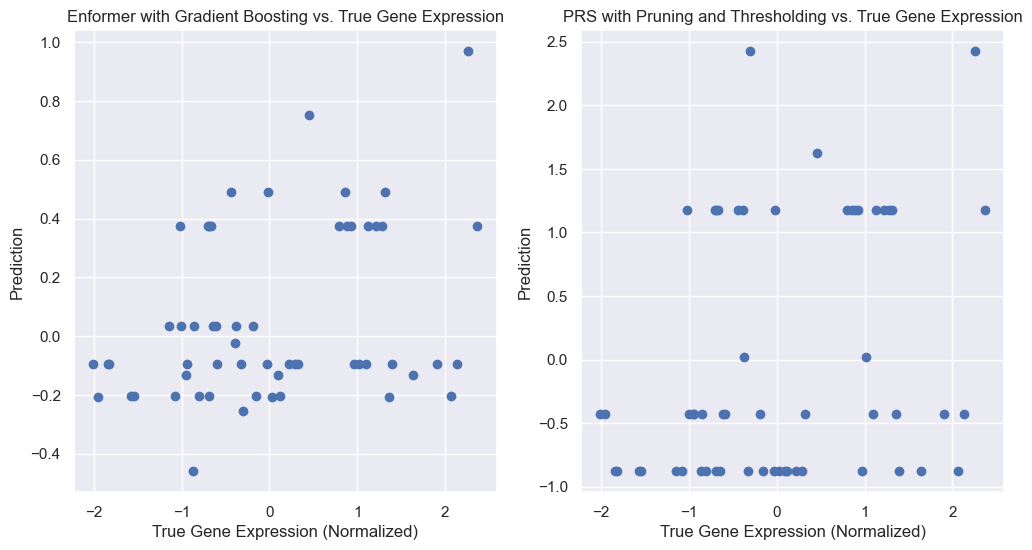

In [186]:
# Set up the figure and axes for subplots
sns.set(font_scale=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First scatter plot
axs[0].scatter(y_test, y_pred_gbr)
axs[0].set_xlabel("True Gene Expression (Normalized)")
axs[0].set_ylabel("Prediction")
axs[0].set_title("Enformer with Gradient Boosting vs. True Gene Expression")

# Second scatter plot
axs[1].scatter(test_expression, norm_prs)
axs[1].set_xlabel("True Gene Expression (Normalized)")
axs[1].set_ylabel("Prediction")
axs[1].set_title("PRS with Pruning and Thresholding vs. True Gene Expression")


In [156]:
corr, p_value = pearsonr(y_test, norm_prs)
p_value

np.float64(0.022023082624041557)

In [165]:
corr, p_value = pearsonr(y_test, y_pred_gbr)
p_value

np.float64(0.012476530088572095)

In [194]:
mean_squared_error(y_test, norm_prs)

1.5977101424806923